<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/lindevanbeers/Lab-5/linde-report-lab-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 5: Quadrature**
**Linde van Beers**

# **Abstract**



```
# This is formatted as code
```

Short summary of the lab report. State the objectives, methods used, main results and conlusions. 

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [63]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

Give a short description of the problem investigated in the report, and provide some background information so that the reader can understand the context. 

Briefly describe what method you have chosen to solve the problem, and justify why you selected that method. 

Here you can express mathematics through Latex syntax, and use hyperlinks for references.

[Hyperlink to DD2363 course website.](https://kth.instructure.com/courses/7500)

$
{\displaystyle \frac{\partial u}{\partial t}} + u\cdot \nabla u +\nabla p = f, \quad \nabla \cdot u=0$



# **Methods**

In [0]:
class RandomPoly:
  def __init__(self, degree):
    self.degree = degree
    self.a = np.random.randint(-5,6,degree+1) # pick random numbers between -5 and 5   
    # print the function:   
    print("f(x) = ", end = '')
    for i in (range(self.degree, 0,-1)):
      print(self.a[i], "* x^",end = '')
      print(i , "+ ",end = '')
    print(self.a[0])

  def function(self,x):
    c = self.a
    y=0
    for i in range(self.degree+1):
      y += c[i] * pow(x,i)
    return y
  
  def integral(self, low, high):
    c = self.a
    y = 0 
    for i in range(self.degree+1):
      y += (1/(i+1)) * c[i] * pow(high,i+1) - (1/(i+1)) * c[i] * pow(low,i+1)
    return y

class Random2dimPoly:
  def __init__(self):
    self.a = np.random.randint(-5,6,6) # pick random numbers between -5 and 5   
    # print the function:   
    print("f(x) = %sx^2 + %sy^2 + %sxy + %sx + %sy + %s" % (self.a[0],self.a[1],self.a[2],self.a[3],self.a[4],self.a[5]))

  def function(self,x):
    # evaluates function at point x
    y = self.a[0] * pow(x[0],2) + self.a[1] * pow(x[1],2) + self.a[2] * x[0] *x[1] + self.a[3] * x[0] + self.a[4] * x[1] + self.a[5]
    return y
  
  def integral(self):
    # calculates integral over referece triangle
    y = (self.a[0]/12 + self.a[1]/12 + self.a[2]/24 + self.a[3]/6 + self.a[4]/6 + self.a[5]/2)
    return y

### 2 point Gauss Quadrature



Describe the methods you used to solve the problem. This may be a combination of text, mathematical formulas (Latex), algorithms (code), data and output.  

I derived $w_0, w_1, x_0$ and $x_1$ as follows:

$\int_0^1 p(x)dx = p(x_0)w_0+p(x_1)w_1 \Leftrightarrow $

$c_3(\frac{1}{4}-x_0^3w_0-x_1^3w_1)+c_2(\frac{1}{3}-x_0^2w_0-x_1^2w_1)+ c_1(\frac{1}{2}-x_0w_0-x_1w_1)+c_0(1-w_0-w_1) = 0$

I then chose $w_0 = w_1 = \frac{1}{2}$ to satify the last term and used the second to last term to find $x_0 = a, x_1 = 1-a$, which gives

$\frac{a^2}{2} + \frac{(1-a)^2}{2} -\frac{1}{3} = 0  \Leftrightarrow$

$a^2 - a+ \frac{1}{6} = 0$

I then used the $abc$-function to find that $a = x_0 = \frac{1}{2} - \frac{1}{\sqrt{12}}$ and $x_1 = 1- (\frac{1}{2} - \frac{1}{\sqrt{12}})= \frac{1}{2} + \frac{1}{\sqrt{12}}$

Then I used quadrature $\int_{0}^{1} f(x)dx \approx \sum\limits_{i=0}^{n}f(x_i)w_i$ using the quadrature points and weights I found to approximate the integral. 

In [0]:
def gauss_quad(f):
  w0 = 1/2
  w1 = 1/2
  x0 = 1/2 - 1/pow(12,1/2)
  x1 = 1/2 + 1/pow(12,1/2)

  # test correctness of values for w's and x's
  assert abs(1/4 - pow(x0,3)*w0 - pow(x1,3)*w1) < 1e-16
  assert abs(1/3 - pow(x0,2)*w0 - pow(x1,2)*w1) < 1e-16
  assert abs(1/2 - x0*w0 - x1*w1) < 1e-16

  ans = f(x0)*w0 + f(x1)*w1
  return ans

### 3-point edge midpoint quadrature


In [0]:
def edge_midpoint_quadrature(f):
  x0 = [0.5, 0. ]
  x1 = [0.5, 0.5]
  x2 = [0. , 0.5]
  w = 1/6 # w0 = w1 = w2 = 1/6

  ans = (f(x0) + f(x1) + f(x2)) * w
  return ans

### Monte Carlo Quadrature


In [0]:
def mc_quadrature(f, n):
  '''
  Performs Monte-Carlo Quadrature on function f 
  in the interval [0,1] with n quadrature points
  '''
  ans = 0
  for i in range(n):
    x = np.random.random()
    ans += f(x)
  ans = ans/n
  return ans

### Monte Carlo quadrature over reference triangle



f(x) = 2x^2 + 5y^2 + -2xy + 1x + 3y + 3



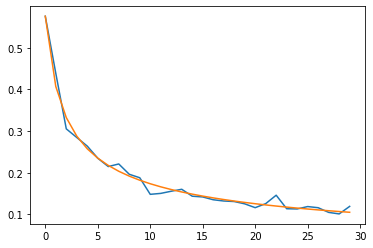

In [99]:
def mc_quadrature_tri(f, n):
  '''
  Performs Monte-Carlo Quadrature on function f 
  in the reference triangle with n quadrature points
  '''
  ans = 0
  for i in range(n):
    # choose a random point in a 1-by-1 square
    x = np.random.random(2)
    # if point is not in reference trangle, mirror it over diagoal 
    if x[1] > 1-x[0]: 
      a = x[0]
      b = x[1]
      x[0] = 1-b
      x[1] = 1-a
    ans += f(x)/2 #divide over 2 because area of ref triangle is 1/2
  ans = ans/n
  return ans

fun = Random2dimPoly()
integral = fun.integral()
errors = []
target = []
for i in range(1,31):
  av_error = 0
  for j in range(100):
    av_error += abs(integral - mc_quadrature_tri(fun.function, i))
  errors.append(av_error/100)
  target.append(1*errors[0]/pow(i,0.5))
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(np.array(range(30)), errors)
sub.plot(np.array(range(30)), target)
print()

# **Results**

Present the results. If the result is an algorithm that you have described under the *Methods* section, you can present the data from verification and performance tests in this section. If the result is the output from a computational experiment this is where you present a selection of that data. 

In [69]:
fun = RandomPoly(3)
print("exact solution:", fun.integral(0,1))
print("quadrature solution:", gauss_quad(fun.function))
print("error:", abs(fun.integral(0,1)-gauss_quad(fun.function)))

f(x) = -4 * x^3 + -3 * x^2 + -4 * x^1 + 5
exact solution: 1.0
quadrature solution: 0.9999999999999999
error: 1.1102230246251565e-16


In [70]:
fun = Random2dimPoly()
print("exact solution:", fun.integral())
print("quadrature solution:", edge_midpoint_quadrature(fun.function))
print("error:", abs(fun.integral()-edge_midpoint_quadrature(fun.function)))

f(x) = -3x^2 + 5y^2 + 2xy + 4x + 5y + 2
exact solution: 2.75
quadrature solution: 2.75
error: 0.0


f(x) = -1 * x^3 + -2 * x^2 + 1 * x^1 + 3



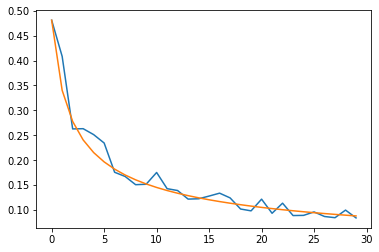

In [78]:
fun = RandomPoly(3)
integral = fun.integral(0,1)
errors = []
target = []
for i in range(1,31):
  av_error = 0
  for j in range(100):
    av_error += abs(integral - mc_quadrature(fun.function, i))
  errors.append(av_error/100)
  target.append(1*errors[0]/pow(i,0.5))
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(np.array(range(30)), errors)
sub.plot(np.array(range(30)), target)
print()

# **Discussion**

Summarize your results and your conclusions. Were the results expected or surprising. Do your results have implications outside the particular problem investigated in this report? 

# **APPENDIX**

In this appendix some examples are given to express and visualizing mathematical concepts such as vectors, matrices, meshes and functions. 

This is not part of the template report for the course.

# **Vector**

In this cell some basic commands are introduced for how to define and process a vector, where the NumPy array data type is used. 

x = [1 2 3 4]
x[2] = 3
x[0:2] = [1 2]
x.shape = (4,)
x.ndim = 1
x.size = 4
x.dtype = int64
x[ 0 ] = 1
x[ 1 ] = 2
x[ 2 ] = 3
x[ 3 ] = 4
x = [1 2 3 4]
xf = [1.  2.1 3.  4. ]
xf.dtype = float64
y = [2.+0.j 3.+0.j 4.+0.j]
y.dtype = complex128
z = [12.  16.5 21.  25.5]
z = [0.         1.57079633 3.14159265 4.71238898 6.28318531]


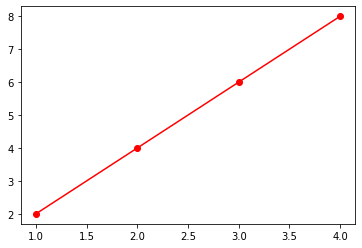

In [72]:
# Just a test
# Create a vector as a NumPy array
x = np.array([1,2,3,4])

# Print various attributes of the vector
print('x =',x)
print('x[2] =',x[2])
print('x[0:2] =',x[0:2])
print('x.shape =',x.shape)
print('x.ndim =',x.ndim)
print('x.size =',x.size)
print('x.dtype =',x.dtype)

# Print the elements of vector x
for i in range(x.size):
  print("x[",i,"] =",x[i])

# Assign a float value to the int vector x
x[1] = 2.1
print('x =',x)

# Copy the int vector x to a float vector xf
xf = x.astype(float)
xf[1] = 2.1
print('xf =',xf)
print('xf.dtype =',xf.dtype)

# Create a complex vector 
y = np.array([2,3,4], dtype=complex)
print('y =',y)
print('y.dtype =',y.dtype)

# Create a vector z by defining a range through an increment
z = np.arange(12, 28, 4.5)
print('z =',z)

# Overwrite the vector z by a vector of uniformly spaced elements in a range
pi=np.pi
pi
z = np.linspace(0, 2*pi, 5)
print('z =',z)

# Visualize the vector in a plot. 
plt.figure()
plt.plot(x,2*x,'ro-')
plt.show()

# **Matrix**

In this cell some basic commands for defining and processing a matrix
is introduced, where we use the NumPy array data type. 

A = [[2 4 6]
 [3 6 9]
 [1 2 1]]
A[1,0] = 3
A.shape = (3, 3)
A.ndim = 2
A.size = 9
Sparse matrix values: 
 [3 2 2 2 1 1 3 2 1 2 3]
Sparse matrix column indices: 
 [1 2 4 2 3 3 3 4 5 5 6]
Sparse matrix row pointer: 
 [ 1  4  6  7  9 10]


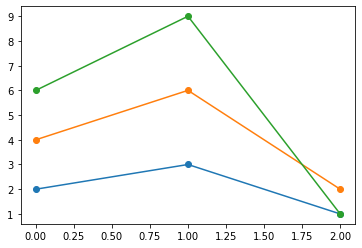

In [73]:
# Define a matrix as a NumPy array
A = np.array([[2,4,6], [3,6,9], [1,2,1]])

# Print various attributes of the matrix 
print('A =',A)
print('A[1,0] =',A[1,0])
print('A.shape =',A.shape)
print('A.ndim =',A.ndim)
print('A.size =',A.size)

# Plot the matrix
plt.figure()
plt.plot(A,'o-')

# Construct a simple sparse matrix class using the CRS data structure
class spMatrix:
  def __init__(self, val, col_idx, row_ptr):
    self.val = val
    self.col_idx = col_idx
    self.row_ptr = row_ptr
    
# Create a sparse matrix object 
val = np.array([3, 2, 2, 2, 1, 1, 3, 2, 1, 2, 3])
col_idx = np.array([1, 2, 4, 2, 3, 3, 3, 4, 5, 5, 6])
row_ptr = np.array([1, 4, 6, 7, 9, 10])
spA = spMatrix(val, col_idx, row_ptr)

# Print sparse matrix object attributes
print('Sparse matrix values: \n',spA.val)
print('Sparse matrix column indices: \n',spA.col_idx)
print('Sparse matrix row pointer: \n',spA.row_ptr)
    

# **Function**

In this cell we illustrate how functions are defined. 

f(3,4) = 7
z = 13
z = 17
z = 14
A = [[1 2 3]
 [4 5 6]
 [7 8 9]]
A =
1  2  3  
4  5  6  
7  8  9  
A^T =
1  4  7  
2  5  8  
3  6  9  


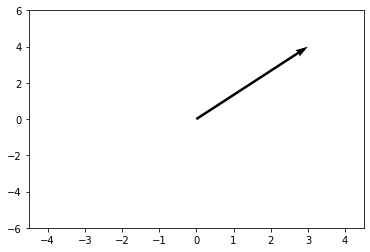

In [74]:
# Define a function f(x,y)
def f(x,y):
  return x + y 

# Verify the function output
print('f(3,4) =',f(3,4))

# Define a function of a function
def g1(fcn,arg1,arg2):
  z = fcn(arg1,arg2)
  print('z =',z)

# Call the function
g1(f,6,7)

# Define a function of a function with arguments in a list or array
def g2(fcn,arg):
  z = fcn(*arg)
  print('z =',z)
  
# Call the function with arguments as list and array
xlist = [8,9]
xarray = np.array([11,3])
g2(f,xlist)
g2(f,xarray)

# Define a function to format the print out for a matrix 
def printMatrix(A):
   rows = A.shape[0]
   cols = A.shape[1]
   for i in range(0,rows):
      for j in range(0,cols):
         print(A[i,j]," ", end='')
      print()

# Define matrix      
A = np.array([[1,2,3], [4,5,6], [7,8,9]])

# Verify the function output
print('A =', A)
print('A =')
printMatrix(A)
print('A^T =')
printMatrix(A.transpose())

# Plot a Euclidian position vector v 
def plotEVector(vec):
  plt.figure()
  plt.xlim([-1.5*vec[0], 1.5*vec[0]])
  plt.ylim([-1.5*vec[1], 1.5*vec[1]])
  plt.quiver(0, 0, vec[0], vec[1], scale=1, scale_units='xy', angles='xy')
  plt.show()

v = np.array([3,4])
plotEVector(v)




# **Plot**

<Figure size 432x288 with 0 Axes>

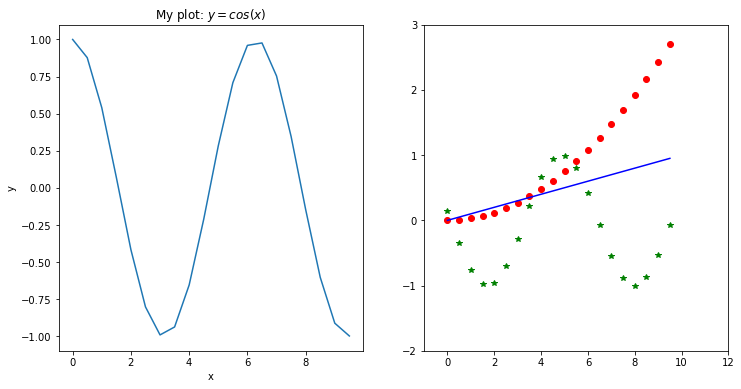

In [75]:
# Define a range for a parameter t
t = np.arange( 0.0, 10, 0.5)

# Initialize a new figure and set the size 
plt.figure(2)
plt.figure(figsize=(12,6))

# Define a subplot structure and choose the first subplot 
plt.subplot(121)

# Plot a standard NumPy function against the parameter t
plt.plot(t,np.cos(t))

# Set plot labels and title for the subplot
plt.xlabel('x')
plt.ylabel('y')
plt.title('My plot: $y = cos(x)$')

# Choose the other subplot
plt.subplot(122)

# Plot three functions in the same subplot
plt.plot(t, np.sin(f(t,3)), 'g*', t, 0.03*t**2, 'ro', t, 0.1*t, 'b')
plt.axis([-1, 12, -2 ,3])

# Show the figure
plt.show()

# Triangular **mesh**

This cell describes how to generate a triangular mesh from a point cloud by the Delaunay algorithm. It also illustrates how to access the mesh data structures. 

Mesh generation took:  0.00919485092163086 seconds (wall-clock time)
vertices = 
 [[0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75
  1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.  ]
 [0.   0.   0.   0.   0.   0.25 0.25 0.25 0.25 0.25 0.5  0.5  0.5  0.5
  0.5  0.75 0.75 0.75 0.75 0.75 1.   1.   1.   1.   1.  ]]
edges = 
 [[ 1  0]
 [ 2  1]
 [ 3  2]
 [ 4  3]
 [ 5  0]
 [ 5  1]
 [ 6  1]
 [ 6  5]
 [ 7  1]
 [ 7  2]
 [ 7  3]
 [ 7  6]
 [ 8  3]
 [ 8  7]
 [ 9  3]
 [ 9  4]
 [ 9  8]
 [10  5]
 [11  5]
 [11  6]
 [11  7]
 [11 10]
 [12  7]
 [12 11]
 [13  7]
 [13  8]
 [13  9]
 [13 12]
 [14  9]
 [14 13]
 [15 10]
 [15 11]
 [16 11]
 [16 15]
 [17 11]
 [17 12]
 [17 13]
 [17 16]
 [18 13]
 [18 17]
 [19 13]
 [19 14]
 [19 18]
 [20 15]
 [21 15]
 [21 16]
 [21 17]
 [21 20]
 [22 17]
 [22 21]
 [23 17]
 [23 18]
 [23 19]
 [23 22]
 [24 19]
 [24 23]]
triangles = 
 [[ 0  1  5]
 [ 5  1  6]
 [ 9  3  4]
 [ 8  3  9]
 [ 6  1  7]
 [ 7  1  2]
 [ 7  3  8]
 [ 2  3  7]
 [20 15 21]
 [21 15 16]
 [ 6  7 1

<Figure size 432x288 with 0 Axes>

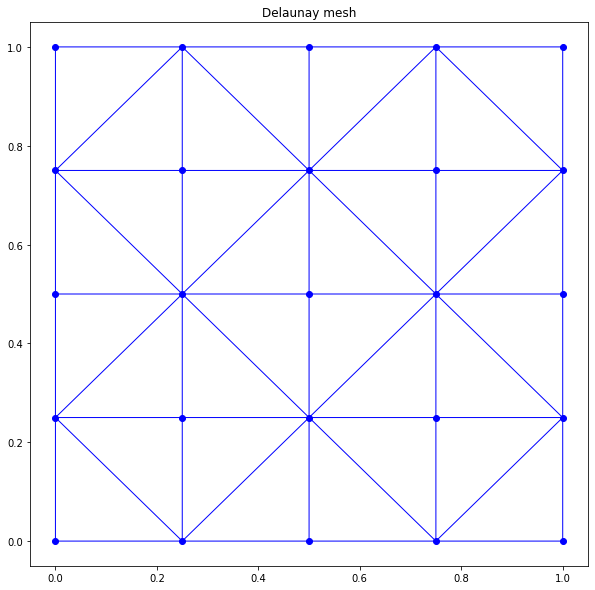

AttributeError: ignored

<Figure size 432x288 with 0 Axes>

In [76]:
# Start the clock 
start = time.time()

# Generate a point cloud
Nx = 5
Ny = 5
hx = 1.0/(Nx-1)
hy = 1.0/(Ny-1)
x = np.zeros((Nx*Ny))
y = np.zeros((Nx*Ny))
for i in range(Nx):
  for j in range(Ny):
    x[i*Nx + j] = j*hx
    y[i*Nx + j] = i*hy

# Generate a mesh from the point cloud using a Delaunay algorithm
mesh = tri.Triangulation( x, y )

# Stop the clock
end = time.time()

# Print the measured time
print ("Mesh generation took: ", end - start, "seconds (wall-clock time)")

# Print mesh data structure
vertices = np.array([mesh.x, mesh.y])
print('vertices = \n', vertices)
print('edges = \n', mesh.edges)
print('triangles = \n', mesh.triangles)
print('neighbor triangles = \n', mesh.neighbors)

# Plot the mesh 
plt.figure(3)
plt.figure(figsize=(10,10))
plt.triplot(mesh, 'bo-', lw=1)
plt.title('Delaunay mesh')
plt.show()

# Define a function g(x,y)
def g(x,y):
    return np.sin(10*x)*np.cos(3*y)

# Plot the function g(x,y) in a contour plot
plt.figure(4)
plt.tricontour(mesh, g(x,y), cmap=plt.cm.spectral)
plt.show()

# Plot the function g(x,y) in 3D as a surface plot
fig = plt.figure(5)
ax1 = fig.add_subplot(111, projection='3d')
surf = ax1.plot_trisurf(mesh, g(x,y), cmap=plt.cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax1.view_init(20,10)
plt.show()

# Parametric **curve**

This cell illustrates how to visualize a parametric curve.

In [0]:
# Define paramter range
t = np.linspace(0, 4*np.pi, 100)

# Define the curve
x = t*np.cos(t)
y = t*np.sin(t)
z = t

fig = plt.figure(6)
ax = fig.gca(projection = '3d')
ax.plot(x, y, z)
plt.title('Parametric curve')
plt.show()